<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/WOOK/Ensemble_voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install torch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-n

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Processing batches: 100%|██████████| 6/6 [02:08<00:00, 21.35s/it]


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.90      0.82        10
     Class 1       0.64      0.90      0.75        10
     Class 2       1.00      0.80      0.89        10
     Class 3       1.00      0.90      0.95        10
     Class 4       0.89      0.80      0.84        10
     Class 5       0.90      0.90      0.90        10
     Class 6       0.88      0.70      0.78        10
     Class 7       1.00      1.00      1.00        10
     Class 8       1.00      0.90      0.95        10
     Class 9       0.86      1.00      0.92         6

    accuracy                           0.88        96
   macro avg       0.89      0.88      0.88        96
weighted avg       0.89      0.88      0.88        96



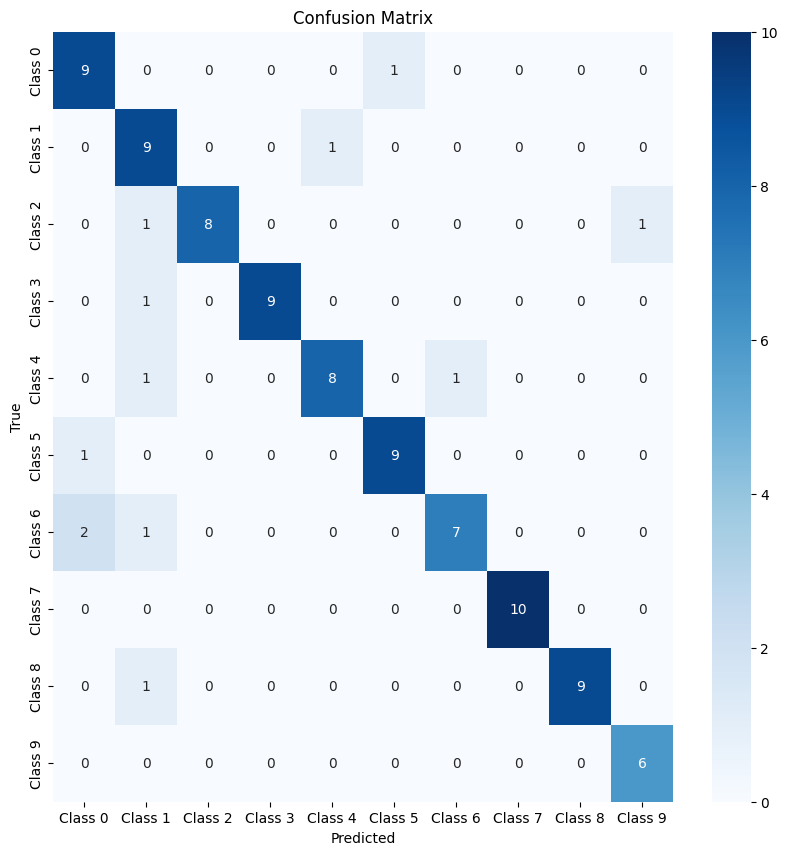

In [2]:
import numpy as np
import torch
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터셋 로드
dataset = load_dataset('csv', data_files='/content/drive/MyDrive/Colab Notebooks/cwe file/MSR+julite+Div_final_test.csv')['train']

# 모델 로드
model_codebert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/codebert")
model_graphcodebert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/graphcodebert3")
model_unixcoder = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/unixcoder")

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base-mlm")

# 데이터 토크나이징 및 포맷 설정
def tokenize_function(examples):
    return tokenizer(examples['code'], truncation=True, padding="max_length", max_length=512)
encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# DataLoader 설정
data_loader = DataLoader(encoded_dataset, batch_size=16, drop_last=True)

# 앙상블 예측 및 레이블 수집
def soft_voting_ensemble(models, data_loader):
    softmax = torch.nn.Softmax(dim=1)
    total_probs = None
    true_labels = []
    predictions_list = []

    for batch in tqdm(data_loader, desc="Processing batches"):
        true_labels.extend(batch['labels'].numpy())
        batch_probs = None
        for model in models:
            model.eval()
            with torch.no_grad():
                outputs = model(**{k: v.to(model.device) for k, v in batch.items()})
                probs = softmax(outputs.logits)
                if batch_probs is None:
                    batch_probs = probs
                else:
                    batch_probs += probs
        batch_probs /= len(models)
        batch_predictions = torch.argmax(batch_probs, dim=1)
        predictions_list.extend(batch_predictions.cpu().numpy())

    return true_labels, predictions_list

# 모델들의 예측 수행
models = [model_codebert, model_graphcodebert, model_unixcoder]
true_labels, predicted_labels = soft_voting_ensemble(models, data_loader)

# 성능 평가 및 결과 시각화
class_names = [f'Class {i}' for i in range(10)]
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# 혼동 행렬 시각화
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
